**Общая информация**

**Срок сдачи:** 21 октября 2019, 08:30 

**Штраф за опоздание:** по 0.5 балла за 24 часа задержки. Через 10 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0919, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Невыполнение PEP8 -0.5 баллов
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [119]:
import numpy as np
import matplotlib.pyplot as plt
import array
import seaborn as sns

from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata, fetch_20newsgroups

from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

from scipy import spatial
from scipy import stats
from scipy import sparse
from collections import Counter
%load_ext pycodestyle_magic


##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

In [111]:
%%pycodestyle
#using Minkowski measure
class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin, ClassifierMixin):

    def __init__(self, n_neighbors = 2, algorithm = 'brute'):
        self.neighbors = n_neighbors
        self.algorithm = algorithm
        
    def setalgorithm(self,algorithm):
        self.algorithm = algorithm
        
    def minkowskimeasure(self,X,Y):
        return spatial.distance.cdist(X,Y,metric = 'minkowski',p = 2)
    
    #fitting is only storing data, because no model is needed to be trained 
    def fit(self, X, y):
        if (X.shape[0] != y.shape[0]):
            print("Incompatible shapes!")
        elif self.algorithm == 'kd_tree':#if use "kd_tree" struct then create index for our data
            self.userKDTree = spatial.KDTree(X)            
        self.train_data = np.asarray(X,dtype=float)
        self.train_targets = np.asarray(y,dtype=int)
        self.features_num = self.train_data.shape[1]#features size
        self.data_volume = self.train_data.shape[0]#sample size
        self.classes = np.unique(y)#classes for classification
        
    #classification prediction(rewritten in numpy)
    def predict(self, X):
        # now we need to find the smallest dist
        if self.algorithm == 'kd_tree':
            kdDistsInd = self.userKDTree.query(X, k = self.neighbors, p = 2)[1]
            return stats.mode(self.train_targets[kdDistsInd],axis = 1)[0].ravel()
        elif self.algorithm == 'brute':
            dists = self.minkowskimeasure(X, self.train_data) # lines - test,columns - train
            dists_ind = np.argpartition(dists, self.neighbors - 1, axis = 1, kind = 'introselect')[:,:self.neighbors]   # need elements with minimal distance(neighbors-1 elements in each group)
            return stats.mode(self.train_targets[dists_ind], axis = 1)[0].ravel()
        
    #probability
    def predict_proba(self, X):
        test_len = len(X)
        res = np.zeros((test_len,len(self.classes)),dtype = float)
        dists = self.minkowskimeasure(X,self.train_data)
        dists_ind = np.argsort(dists,axis = 1)[:,:self.neighbors]#indexes of k nearest
        for line in range(self.train_targets[dists_ind].shape[0]):#k nearest classes for each test
            for column in range(self.train_targets[dists_ind].shape[1]):
                test_class = self.train_targets[dists_ind][line][column]
                res[line,test_class] += 1
        return res/self.neighbors
    
    #Returns the mean accuracy on the given test data and test labels(Q)(score as accuracy:L(a,x,y) = (a(x) == y)) )
    def score(self, X, y):
        if (X.shape[0] != y.shape[0]):
            print('Incompatible shapes!')
        else:
            return np.mean(self.predict(X) == y)
    
    def trainscore(self):
        return np.mean(self.predict(self.train_data) == self.train_targets)

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [112]:
iris = datasets.load_iris()

In [113]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

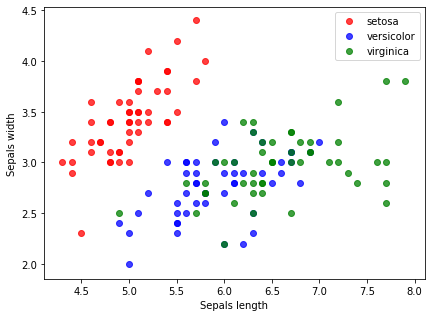

In [114]:
fig = plt.figure(figsize = (15, 5))
ax1 = fig.add_subplot(121)
plt.xlabel('Sepals length')
plt.ylabel('Sepals width')
plt.scatter(iris.data[:,0][iris.target == 0],iris.data[:,1][iris.target == 0],alpha = 0.75,color='red',label='setosa')
plt.scatter(iris.data[:,0][iris.target == 1],iris.data[:,1][iris.target == 1],alpha = 0.75,color='blue',label='versicolor')
plt.scatter(iris.data[:,0][iris.target == 2],iris.data[:,1][iris.target == 2],alpha = 0.75,color='green',label='virginica')
plt.legend()

In [115]:
clf = KNeighborsClassifier(n_neighbors = 2, algorithm = 'brute')
my_clf = MyKNeighborsClassifier(n_neighbors = 2, algorithm = 'brute')

In [116]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [117]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test)) < 0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy

In [57]:
%time clf.fit(X_train, y_train)

CPU times: user 1.06 ms, sys: 45 µs, total: 1.1 ms
Wall time: 721 µs


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [58]:
%time my_clf.fit(X_train, y_train)

CPU times: user 196 µs, sys: 0 ns, total: 196 µs
Wall time: 148 µs


In [59]:
%time clf.predict(X_test)

CPU times: user 3.16 ms, sys: 4.16 ms, total: 7.32 ms
Wall time: 5.48 ms


array([0, 1, 2, 1, 0, 0, 0, 1, 2, 0, 2, 2, 1, 1, 2])

In [60]:
%time my_clf.predict(X_test)

CPU times: user 3.89 ms, sys: 0 ns, total: 3.89 ms
Wall time: 3.06 ms


array([0, 1, 2, 1, 0, 0, 0, 1, 2, 0, 2, 2, 1, 1, 2])

In [61]:
%time clf.predict_proba(X_test)

CPU times: user 3.71 ms, sys: 0 ns, total: 3.71 ms
Wall time: 2.53 ms


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [62]:
%time my_clf.predict_proba(X_test)

CPU times: user 2.63 ms, sys: 116 µs, total: 2.74 ms
Wall time: 1.83 ms


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

In [63]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm = 'kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm = 'kd_tree')

In [64]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size = 0.1, stratify = iris.target)

In [65]:
%time clf.fit(X_train, y_train)

CPU times: user 2.54 ms, sys: 0 ns, total: 2.54 ms
Wall time: 5.45 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [95]:
%time my_clf.fit(X_train, y_train)

CPU times: user 6.19 ms, sys: 102 µs, total: 6.3 ms
Wall time: 4.92 ms


In [67]:
%time clf.predict(X_test)

CPU times: user 6.15 ms, sys: 272 µs, total: 6.42 ms
Wall time: 5.36 ms


array([1, 0, 2, 0, 0, 1, 0, 2, 2, 2, 0, 1, 1, 1, 2])

In [79]:
%time my_clf.predict(X_test)

CPU times: user 7.19 ms, sys: 144 µs, total: 7.33 ms
Wall time: 6.44 ms


array([1, 0, 2, 0, 0, 1, 0, 2, 2, 2, 0, 1, 1, 1, 2])

In [96]:
%time clf.predict_proba(X_test)

CPU times: user 3.34 ms, sys: 0 ns, total: 3.34 ms
Wall time: 2.52 ms


array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [97]:
%time my_clf.predict_proba(X_test)

CPU times: user 4.37 ms, sys: 206 µs, total: 4.57 ms
Wall time: 2.6 ms


array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [98]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test)) < 0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [99]:
newsgroups = fetch_20newsgroups(subset ='train',remove = ['headers','footers', 'quotes'])

In [100]:
data = newsgroups['data']
target = newsgroups['target']
# len(data)

Переведите во всех документах все буквы в нижний регистр и замените во всех документах символы, не
являющиеся буквами и цифрами, на пробелы. Далее разбейте текста по пробельным символам на токены(термы/слова). Удалите текста, содержащие только пробелы.

In [101]:
data_tk = [text.lower() for text in data if text]
data_tok = []
for text in data_tk:
    txt = ''.join([' ' if not (c.isdigit() or c.isalpha()) else c for c in text])
    splitted = txt.split(' ')
    data_tok.append(splitted)
data_tok    
#realize here
# data_tok should be a list of lists of tokens for each line in data.

[['i',
  'was',
  'wondering',
  'if',
  'anyone',
  'out',
  'there',
  'could',
  'enlighten',
  'me',
  'on',
  'this',
  'car',
  'i',
  'saw',
  'the',
  'other',
  'day',
  '',
  'it',
  'was',
  'a',
  '2',
  'door',
  'sports',
  'car',
  '',
  'looked',
  'to',
  'be',
  'from',
  'the',
  'late',
  '60s',
  '',
  'early',
  '70s',
  '',
  'it',
  'was',
  'called',
  'a',
  'bricklin',
  '',
  'the',
  'doors',
  'were',
  'really',
  'small',
  '',
  'in',
  'addition',
  '',
  'the',
  'front',
  'bumper',
  'was',
  'separate',
  'from',
  'the',
  'rest',
  'of',
  'the',
  'body',
  '',
  'this',
  'is',
  '',
  'all',
  'i',
  'know',
  '',
  'if',
  'anyone',
  'can',
  'tellme',
  'a',
  'model',
  'name',
  '',
  'engine',
  'specs',
  '',
  'years',
  'of',
  'production',
  '',
  'where',
  'this',
  'car',
  'is',
  'made',
  '',
  'history',
  '',
  'or',
  'whatever',
  'info',
  'you',
  'have',
  'on',
  'this',
  'funky',
  'looking',
  'car',
  '',
  'please

In [102]:
#map word on number(1<->1), used in csr
uniquedict = {}

n = 0
for sublist in data_tok:
    for item in sublist:
        if item not in uniquedict.keys():
            uniquedict[item] = n
            n += 1

In [103]:
assert all(isinstance(row, (list, tuple)) for row in data_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower() , map(' '.join, data_tok))), "please make sure that you lowercase the data and drop spaced texts"

Преобразуйте датасет в разреженную матрицу scipy.sparse.csr_matrix, где значение x в позиции (i, j)
означает, что в документе i слово j встретилось x раз

In [104]:
lst_counters = {}
i = 0
for lst in data_tok:
    lst_counter = Counter(lst)
    lst_counters[i] = lst_counter
    i += 1
lst_counters
data = []
row = []
column = []
for i in lst_counters.keys():
    lst_counter = lst_counters[i]
    for key in lst_counter.keys():
        row.append(i)
        column.append(uniquedict[key])
        data.append(lst_counter[key])
csr_mtrx = sparse.csr_matrix((data,(row,column))).todense()
print(cst_mtrx)

MemoryError: Unable to allocate array with shape (11096, 98750) and data type int64

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(csr_mtrx,target,test_size=0.1,stratify = target)

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальный score в среднем на валидации на 3 фолдах).
Постройте график зависимости среднего score от количества соседей. Можно рассмотреть число соседей от 1 до 10.

ValueError: axes don't match array

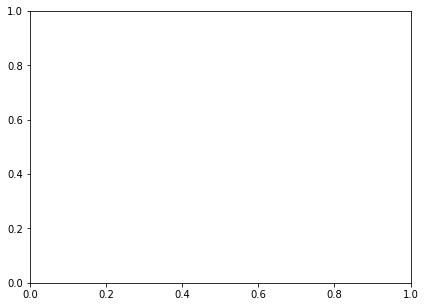

In [105]:
def optimalneighbors(train,target):
    possible_neighbors = range(1,10)
    myknn = MyKNeighborsClassifier()
    grid = GridSearchCV(myknn, param_grid={'possible_neighbors': possible_neighbors},cv = 3)
    grid.fit(train,target)
    return (grid.best_score_,grid.best_estimator_.possible_neighbors)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)

x = np.arange(1,10)
y = np.empty(9,dtype=float)#score
for i in range(1,10):
    myknn = MyKNeighborsClassifier(n_neighbors = i,algorithm = 'kd_tree')
    myknn.fit(X_train,y_train)
    res[i] = myknn.score(X_test,y_test)

    
plot.plot(x,y)

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf преобразование( sklearn.feature_extraction.text.TfidfTransformer)

Сравните модели, выберите лучшую.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [106]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим качество(score) вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.